# Домашнее задание 3. Линейная интерполяция

## Введение

На практике физические свойства газа (вязкость, коэффициент сверхсжимаемости, объёмный коэффициент и др.) известны лишь в дискретных точках — из лабораторных измерений или табличных расчётов. Чтобы получить значение свойства при произвольном давлении, необходима **интерполяция**.

**Линейная интерполяция** — простейший и наиболее распространённый метод: между двумя соседними известными точками $(x_i,\, y_i)$ и $(x_{i+1},\, y_{i+1})$ значение приближается прямой линией:

$$
y_p = y_i + \frac{y_{i+1} - y_i}{x_{i+1} - x_i} \cdot (x_p - x_i)
$$

где $x_p$ — точка, в которой нужно найти значение, а $y_p$ — результат интерполяции.

## Задание

### Что нужно сделать

1. **Считать файл `interp_data.csv`** и загрузить данные давления и вязкости.

2. **Дополнить таблицу столбцами Z и Bg** — используя класс `Fluid` из ДЗ-2, рассчитать коэффициент сверхсжимаемости и объёмный коэффициент расширения для каждого давления при фиксированной температуре $T = 310$ К.

3. **Реализовать класс `LinearInterpolator`** — собственный линейный интерполятор **без использования** встроенных функций интерполяции (numpy, scipy, pandas и т.д.).
   - Класс инициализируется массивами `x` и `y`.
   - Метод `predict(xp)` возвращает интерполированное значение $y_p$ для заданного $x_p$.

4. **Сравнить свой интерполятор с `numpy.interp`** — построить графики, на которых видно совпадение (или расхождение) результатов.

---

## Часть 1. Загрузка и обогащение данных

Считайте файл `interp_data.csv`. Затем вставьте свой класс `Fluid` из ДЗ-2 (с реализованными методами `get_Z` и `get_Bg`) и создайте объект `Fluid` со своими параметрами из `hw2_data.csv`.

Для каждого давления из таблицы рассчитайте Z и Bg при $T = 310$ К и добавьте результаты как новые столбцы.

,"pressure, atm","viscosity, cP"
0,1.000000,0.018312
1,3.010101,0.018321
2,5.020202,0.018330
3,7.030303,0.018339
4,9.040404,0.018349


Attention - давление газа в не диапазона 0 < P < 30 МПа, P:20.0
Attention - давление газа в не диапазона 0 < P < 30 МПа, P:20.0


,"pressure, atm","viscosity, cP",z,Bg
0,1.000000,0.018312,0.997948,1.069292
1,3.010101,0.018321,0.993839,0.353772
2,5.020202,0.018330,0.989751,0.211248
3,7.030303,0.018339,0.985686,0.150229
4,9.040404,0.018349,0.981645,0.116347


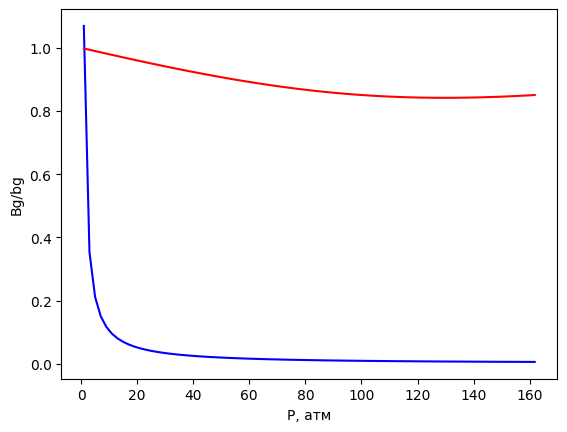

In [351]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === Вставьте сюда свой класс Fluid из ДЗ-2 (с реализованными get_Z и get_Bg) ===

class Fluid:
    """Класс для расчёта свойств природного газа по методике GERG-91 мод."""
    
    Pstd = 0.101325     # стандартное давление, МПа
    Tstd = 293.15       # стандартная температура, К
    
    def __init__(self, rho_c: float, xa: float, xy: float):
        self.rho_c = rho_c
        self.xa = xa
        self.xy = xy
    
    def get_Z(self, P: float, T: float) -> float:

        # Блок проверки на условия применимости
        if not(self.rho_c > 0.668 and self.rho_c < 0.700):
            print(f'Attention - плотность газа в не диапазона 0.668 < ro < 0.700 кг/м3, ro:{self.rho_c}')
        if not(np.any(T > 250 and T < 330)):
            print(f'Attention - температура газа в не диапазона 250 < T < 340 K, K:{T}')
        if not np.all((P > 0) & (P < 12)):
            if np.any((P <= 0) | (P >= 30)):
                print(f'Attention - давление газа в не диапазона 0 < P < 12 МПа, P:{np.max(P)}, погрешность расчёта +/- 3,0%')
            else:
                print(f'Attention - давление газа в не диапазона 0 < P < 30 МПа, P:{np.max(P)}')

        xe = 1 - self.xa - self.xy # дол.ед, эквивалент углеводорода
        zc = 1-(0.0741*self.rho_c-0.006-0.063*self.xa-0.0575*self.xy)**2 # дол.ед, фактор сжимаемости при стандартных условиях
        Me = (24.05525*zc*self.rho_c-28.0135*(self.xa)-44.01*(self.xy))/xe # г/моль, Молярная масса эквивалетного углеводорода

        H = 128.64 + 47.479 * Me
        Cx = 0.92 + 0.0013 * (T - 270)
        Bx = 0.72 + 1.875*10**-5 * (320 - T)**2

        C233 = 3.58783*10**-3 + 8.06674*10**-6 * T - 3.25798*10**-8 * T**2
        C223 = 5.52066*10**-3 - 1.68609*10**-5 * T + 1.57169*10**-8 * T**2

        C3 = 2.0513*10**-3 + 3.4888*10**-5*T - 8.3703*10**-8 * T**2
        C2 = 7.8498*10**-3 - 3.9895*10**-5*T + 6.1187*10**-8 * T**2
        C1 = (-0.302488 + 1.95861*10**-3*T - 3.16302*10**-6 * T**2
              + (6.46422*10**-4 - 4.22876*10**-6*T + 6.88157*10**-9*T**2) * H
              + (-3.32805*10**-7 + 2.2316*10**-9*T - 3.67713*10**-12*T**2) * H**2)

        B3 = -0.86834 + 4.0376 * 10**-3 * T - 5.1657 * 10**-6 * T**2
        B23 = -0.339693 + 1.61176 * 10**-3 * T - 2.04429 * 10**-6 * T**2
        B2 = -0.1446 + 7.4091 * 10**-4 * T - 9.1195 * 10**-7 * T**2
        B1 = (-0.425468 + 2.865e-3 * T - 4.62073e-6 * T ** 2
               + (8.77118e-4 - 5.56281e-6 * T + 8.8151e-9 * T ** 2) * H
               + (-8.24747e-7 + 4.31436e-9 * T - 6.08319e-12 * T ** 2) * H ** 2)

        Cm = (xe**3 * C1 + 3 * xe**2 * self.xa * Cx * (C1**2 * C2)**(1/3) + 2.76 * xe**2 * self.xy * (C1**2 * C3)**(1/3)
              + 3 *xe*self.xa**2*Cx*(C1*C2**2)**(1/3) + 6.6*xe*self.xa*self.xy*(C1 * C2 * C3)**(1/3) + 2.76 * xe * self.xy**2 * (C1 * C3**2)**(1/3)
              + self.xa**3* C2 + 3 *self.xa**2 * self.xy*C223 + 3 * self.xa*self.xy**2*C233 + self.xy**3 * C3)

        Bm = (xe**2*B1 + xe*self.xa*Bx*(B1+B2)-1.73*xe*self.xy*(B1*B3)**0.5
              +self.xa**2*B2+2*self.xa*self.xy*B23+self.xy**2*B3)

        # GERG-91 mod, P в МПа
        b = 10**3 * (P / (2.7715*T))
        C0 = b**2 * Cm
        B0 = b * Bm
        A1 = 1 + B0
        A0 = 1 + 1.5 * (B0 + C0)
        A2 = (A0 - (A0**2 - A1**3)**0.5)**(1/3)

        Z = (1 + A2 + A1/A2) / 3
        # Для тестов
        # K = Z/zc

        return Z

    def get_Bg(self, P: float, T: float) -> float:

        Bg = (self.Pstd * self.get_Z(P, T) * T) / ((P) * self.Tstd)

        return Bg

# === Загрузка данных ===

df = pd.read_csv('interp_data.csv', sep=';')
display(df.head())

# === Создание объекта Fluid (подставьте свои параметры из hw2_data.csv) ===

rho_c = 0.6799  # TODO: ваше значение плотности
xa = 0.4319     # TODO: ваша мольная доля азота
xy = 0.2912     # TODO: ваша мольная доля CO₂

fluid = Fluid(rho_c=rho_c, xa=xa, xy=xy)

# === Расчёт Z и Bg для каждого давления при T = 310 К ===

T = 310  # К
pressure_list = df['pressure, atm']/10

all_z = fluid.get_Z(pressure_list,T)
all_bg = fluid.get_Bg(pressure_list,T)

df['z'] = all_z
df['Bg'] = all_bg

plt.plot(pressure_list*10, all_bg, color='b')
plt.plot(pressure_list*10, all_z, color='r')
plt.xlabel('P, атм')
plt.ylabel('Bg/bg')

display(df.head())


---

## Часть 2. Собственный интерполятор

Реализуйте класс `LinearInterpolator`.

### Требования

- `__init__(self, x, y)` — принимает два списка (или массива) одинаковой длины. Значения `x` должны быть отсортированы по возрастанию.
- `predict(self, xp)` — принимает скалярное значение `xp` и возвращает интерполированное значение `yp`.
- **Запрещено** использовать `numpy`, `scipy`, `pandas` и любые другие библиотечные функции интерполяции внутри класса. Только чистый Python (`list`, `for`, `if`, арифметика).

### Подсказка

Алгоритм для `predict(xp)`:
1. Найти индекс $i$ такой, что $x_i \le x_p < x_{i+1}$.
2. Применить формулу линейной интерполяции:

$$
y_p = y_i + \frac{y_{i+1} - y_i}{x_{i+1} - x_i} \cdot (x_p - x_i)
$$

> Что делать, если `xp` совпадает с последней точкой $x_n$? Обработайте этот граничный случай через экстраполяцию по двум граничным точкам

In [348]:
class LinearInterpolator:
    """
    Линейный интерполятор.
    
    Параметры
    ----------
    x : list
        Узловые точки (отсортированы по возрастанию).
    y : list
        Значения функции в узловых точках.
    """
    
    def __init__(self, x, y):
        # TODO: сохранить x и y, проверить что длины совпадают

        if len(x) == len(y):
            self.x = x
            self.y = y

        else:
            print(f'Attention - количество x,y не совпадает, x,y:{len(x),len(y)}')
            self.x = None
            self.y = None

            


    def predict(self, xp):
        """
        Вычислить интерполированное значение yp для заданного xp.
        
        Параметры
        ----------
        xp : float
            Точка, в которой нужно найти значение.
        
        Возвращает
        ----------
        float
            Интерполированное значение yp.
        """
        # TODO: реализовать линейную интерполяцию

        # if not(np.isscalar(xp)): # проверка на иттерабильность
        #     xp = np.asarray(xp)
        #     return np.array([self.predict(i) for i in xp])

        if not isinstance(xp, (int, float)):
            return [self.predict(i) for i in xp]

        if xp < min(self.x) or xp > max(self.x):
            # print(f'Attention - xp({xp}) лежит за пределами диапазона x:{max(self.x),min(self.x)},\n'
            #       f'Будет произведена экстрополяция')

            if xp < min(self.x):
                x1, y1 = self.x[0], self.y[0]
                x2, y2 = self.x[1], self.y[1]

            if xp > max(self.x):
                x1, y1 = self.x.iloc[-2], self.y.iloc[-2]
                x2, y2 = self.x.iloc[-1], self.y.iloc[-1]

            return y1 + (xp - x1) * (y2 - y1) / (x2 - x1)

        # --- Линейный поиск со сложностью O(n)
        # for idx, i in enumerate(self.x):
        #     if i == xp:
        #         return self.y[idx]

        #     if self.x[idx] < xp < self.x[idx+1]:
        #         # y1 + (xp - x1) * (y2 - y1) / (x2 - x1)
        #         return (self.y[idx] + (xp - self.x[idx]) 
        #                 * (self.y[idx+1] - self.y[idx]) 
        #                 / (self.x[idx+1] - self.x[idx]))
        
        # --- Бинарный поиск O(log n)
        left = 0
        right = len(self.x) - 1

        while right - left > 1:
            mid = (left + right) // 2

            if self.x[mid] == xp:
                return self.y[mid]

            elif self.x[mid] < xp:
                left = mid
            else:
                right = mid

        x1 = self.x[left]
        x2 = self.x[right]
        y1 = self.y[left]
        y2 = self.y[right]

        return y1 + (xp - x1) * (y2 - y1) / (x2 - x1)


---

## Часть 3. Сравнение с `numpy.interp`

Сгенерируйте набор промежуточных точек давления (например, 500 точек в диапазоне от 1 до 200 атм). Вычислите интерполированные значения **вязкости**, **Z** и **Bg** двумя способами:

1. Ваш `LinearInterpolator`
2. Функция `numpy.interp`

Постройте графики, на которых отображены:
- Исходные табличные точки (маркерами)
- Кривая вашего интерполятора
- Кривая `numpy.interp`

In [349]:
import time

x = df['pressure, atm']
y = df['viscosity, cP']

press_visc = np.linspace(-5, 220, 500)
viscosity = LinearInterpolator(x, y)

n_runs = 100

# --- np.interp
start = time.perf_counter()
for _ in range(n_runs):
    np.interp(press_visc, x, y)
time_np = (time.perf_counter() - start) / n_runs

# --- predict
start = time.perf_counter()
for _ in range(n_runs):
    viscosity.predict(press_visc)
time_custom = (time.perf_counter() - start) / n_runs

print(f"Среднее время np.interp: {time_np:.6e} сек")
print(f"Среднее время predict(): {time_custom:.6e} сек")
print(f"np.interp быстрее примерно в {time_custom / time_np:.1f} раз")

Среднее время np.interp: 3.204500e-05 сек
Среднее время predict(): 1.906221e-02 сек
np.interp быстрее примерно в 594.9 раз


<span style="color: #00FF00;"> Хоть мой код и не быстрее, зато он умеет экстраполировать

Графики:

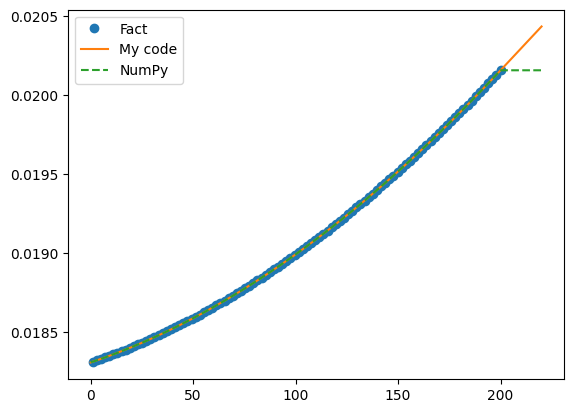

In [350]:
press_visc = np.linspace(0, 220, 500)

plt.figure()
plt.plot(x, y, 'o', label='Fact')

plt.plot(press_visc, viscosity.predict(press_visc)
         , '-', label='My code')

plt.plot(press_visc, np.interp(press_visc, x, y)
         , '--', label='NumPy')
plt.legend()